### **Tissue-Specific Biomarker Discovery Using GTEx RNA Expression Profiles**

**Introduction**<br>
dentifying reliable biomarkers is essential for improving disease diagnosis, patient stratification, and the overall success of clinical trials. Tissue‑specific expression patterns offer a powerful lens for discovering biomarkers that are biologically meaningful and clinically actionable. The GTEx (Genotype‑Tissue Expression) project provides one of the most comprehensive resources of tissue‑resolved RNA expression across 54 human tissues, making it an ideal dataset for investigating gene–tissue specificity.

**Problem** <br>
Many biomarkers fail in clinical translation because they lack true tissue specificity or are selected without robust expression evidence. In drug development and precision medicine, this leads to inaccurate patient selection, increased trial failures, and wasted resources. Without integrating tissue‑level transcriptomic patterns, it is difficult to determine which genes are genuinely enriched in disease‑relevant tissues.

**Objective** <br>
The goal of this project is to leverage GTEx v8 RNA expression data to identify and prioritize tissue‑specific biomarkers. Specifically, the system aims to:

1. Quantify gene–tissue specificity using GTEx median TPM values<br>
2. Identify top tissue‑enriched genes using Tau specificity scoring<br>
3. Validate against known positive controls such as KLK3 (PSA), MUC16 (CA‑125), and TNNT2 (Troponin) <br>
4. Generate ranked biomarker candidates for downstream disease applications <br>

#### Mounting Google Drive

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Set Working Directory

In [ ]:
!cd drive/MyDrive/2025/BenchSci_Hackathon

In [3]:
# 2. Specify path to .gz file in Google Drive
gz_tpm = '/content/drive/MyDrive/BenchSci Hackathon/gtex_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz'
gz_med = '/content/drive/MyDrive/BenchSci Hackathon/gtex_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
sub_phen = '/content/drive/MyDrive/BenchSci Hackathon/gtex_GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'
samp_att = '/content/drive/MyDrive/BenchSci Hackathon/gtex_GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt'

#### Preview GTEx Compressed Data File

In [4]:
import gzip
import os

# Choose which .gz file to view (gz_tpm or gz_med)
gz_file_to_view = gz_med # Or change to gz_med

# Check if the file exists
if os.path.exists(gz_file_to_view):
    try:
        with gzip.open(gz_file_to_view, 'rt', encoding='utf-8') as f:
            print(f"Displaying first 10 lines of: {gz_file_to_view}\n")
            for i, line in enumerate(f):
                if i < 10:
                    print(line.strip())
                else:
                    break
    except Exception as e:
        print(f"Error reading the .gz file: {e}")
else:
    print(f"Error: The file '{gz_file_to_view}' was not found. Please check the path.")

Displaying first 10 lines of: /content/drive/MyDrive/BenchSci Hackathon/gtex_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz

#1.2
56200	54
Name	Description	Adipose - Subcutaneous	Adipose - Visceral (Omentum)	Adrenal Gland	Artery - Aorta	Artery - Coronary	Artery - Tibial	Bladder	Brain - Amygdala	Brain - Anterior cingulate cortex (BA24)	Brain - Caudate (basal ganglia)	Brain - Cerebellar Hemisphere	Brain - Cerebellum	Brain - Cortex	Brain - Frontal Cortex (BA9)	Brain - Hippocampus	Brain - Hypothalamus	Brain - Nucleus accumbens (basal ganglia)	Brain - Putamen (basal ganglia)	Brain - Spinal cord (cervical c-1)	Brain - Substantia nigra	Breast - Mammary Tissue	Cells - Cultured fibroblasts	Cells - EBV-transformed lymphocytes	Cervix - Ectocervix	Cervix - Endocervix	Colon - Sigmoid	Colon - Transverse	Esophagus - Gastroesophageal Junction	Esophagus - Mucosa	Esophagus - Muscularis	Fallopian Tube	Heart - Atrial Appendage	Heart - Left Ventricle	Kidney - Cortex	Kidney - Medulla	Liver

#### Load GTEx .gct File into a DataFrame

In [5]:
import pandas as pd
import numpy as np

def read_gtex_gct(path: str) -> pd.DataFrame:
    """
    Reads a GTEx .gct (optionally .gz) file into a DataFrame.
    Returns a DataFrame indexed by gene 'Name' (often Ensembl IDs),
    with one column per tissue (median TPM).
    """
    # GTEx GCT format usually:
    # line 1: #1.2
    # line 2: <n_rows> <n_cols>
    # line 3: header: Name Description <tissue1> <tissue2> ...
    df = pd.read_csv(path, sep="\t", skiprows=2)

    # Keep gene ID columns
    if "Name" not in df.columns:
        raise ValueError("Expected column 'Name' not found. Check file format.")

    # Rename columns
    df = df.rename(columns={"Name":"ensembl_id","Description":"gene"})

    # Drop period
    df["ensembl_id"] = df["ensembl_id"].str.split(".").str[0]

    # Identify columns to convert to numeric (all except 'ensembl_id' and 'gene')
    cols_to_numeric = [col for col in df.columns if col not in ['ensembl_id', 'gene']]

    # Convert only identified columns to numeric
    df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors="coerce")

    return df

In [6]:
med_tpm_df = read_gtex_gct(gz_med)

In [ ]:
display(med_tpm_df.head(100))

,ensembl_id,gene,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972,DDX11L1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.166403,0.00000,0.000000,0.00000,0.000000
1,ENSG00000227232,WASH7P,4.064030,3.371110,2.685490,4.047620,3.900760,3.639630,5.163750,1.438590,...,5.932980,6.132650,4.19378,5.92631,3.062480,4.702530,6.27255,7.190010,5.74554,2.647430
2,ENSG00000278267,MIR6859-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
3,ENSG00000243485,MIR1302-2HG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.054223,0.00000,0.000000,0.00000,0.000000
4,ENSG00000237613,FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ENSG00000169962,TAS1R3,0.506393,0.519879,0.521956,0.485234,0.575544,0.346047,0.520204,0.363716,...,0.634737,0.712587,2.88212,5.80259,0.689365,2.121720,1.33398,0.927422,1.41623,0.919790
96,ENSG00000107404,DVL1,58.520400,52.217200,64.190100,69.140900,65.668500,69.495900,75.994100,67.381100,...,82.521200,83.042900,49.88950,46.84940,65.764000,135.589000,86.67090,95.312700,84.96680,10.163400
97,ENSG00000284372,MIR6808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
98,ENSG00000162576,MXRA8,216.062000,109.141000,23.924900,264.470000,186.386000,163.884000,132.369000,11.277900,...,57.173400,80.684100,52.73540,69.21260,33.310300,50.993600,143.68200,247.592000,155.65900,0.800333


In [7]:
med_tpm_df.columns[:]

Index(['ensembl_id', 'gene', 'Adipose - Subcutaneous',
       'Adipose - Visceral (Omentum)', 'Adrenal Gland', 'Artery - Aorta',
       'Artery - Coronary', 'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Fallopian Tube',
       'Heart - Atrial Appendage', 'Heart - Lef

In [8]:
# Tissue columns (skip first 2: ensembl_id & gene_symbol)
tissue_cols = med_tpm_df.columns[2:]
tissue_cols

Index(['Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)',
       'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary',
       'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex', 'Brain - Frontal Cortex (BA9)',
       'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)', 'Brain - Spinal cord (cervical c-1)',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - Cultured fibroblasts', 'Cells - EBV-transformed lymphocytes',
       'Cervix - Ectocervix', 'Cervix - Endocervix', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscularis', 'Fallopian Tube',
       'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Kidney 

#### Compute Tissue Specificity Using Tau Score

In [9]:
# Compute Tissue Specificity using Tau Score - From Laud
import numpy as np

# Tau function
def tau_score(row):
    x = np.array(row)
    if np.max(x) == 0:
        return 0
    return np.sum(1 - (x / np.max(x))) / (len(x) - 1)

In [10]:
# Compute Tau
med_tpm_df['Tau Score'] = med_tpm_df[tissue_cols].apply(tau_score, axis=1)

# Preview top tissue-specific genes
med_tpm_df.sort_values('Tau Score', ascending=False).head(100)

,ensembl_id,gene,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,Tau Score
6158,ENSG00000228034,HMGN2P21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
6154,ENSG00000224606,TGFA-IT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.054673,0.0,0.0,0.0,0.0,1.0
6152,ENSG00000229229,AC022201.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.108088,0.0,0.0,0.0,0.0,1.0
44356,ENSG00000267035,RP11-1094M14.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
6173,ENSG00000234485,OR7E46P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.106080,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20483,ENSG00000228015,AC074338.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.162776,0.0,0.0,0.0,0.0,1.0
20481,ENSG00000241420,RN7SL505P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
20457,ENSG00000231418,AC006380.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.573300,0.0,0.0,0.0,0.0,1.0
20701,ENSG00000283247,RP11-638I8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.077344,0.0,0.0,0.0,0.0,1.0


#### Compute Tau Specificity for All Genes

In [11]:
'''def tau_specificity(median_tpm: pd.DataFrame, eps: float = 1e-8) -> pd.Series:
    x = median_tpm.to_numpy(dtype=float)

    max_x = np.max(x, axis=1)
    max_x = np.where(max_x < eps, eps, max_x)

    x_norm = x / max_x[:, None]
    n = x.shape[1]

    tau = np.sum(1.0 - x_norm, axis=1) / (n - 1)
    return pd.Series(tau, index=median_tpm.index, name="Tau Specificity")'''

'def tau_specificity(median_tpm: pd.DataFrame, eps: float = 1e-8) -> pd.Series:\n    x = median_tpm.to_numpy(dtype=float)\n\n    max_x = np.max(x, axis=1)\n    max_x = np.where(max_x < eps, eps, max_x)\n\n    x_norm = x / max_x[:, None]\n    n = x.shape[1]\n\n    tau = np.sum(1.0 - x_norm, axis=1) / (n - 1)\n    return pd.Series(tau, index=median_tpm.index, name="Tau Specificity")'

#### Validate Positive Controls

In [17]:
positive_controls = ["KLK3", "MUC16", "TNNT2"]
med_tpm_df[med_tpm_df["gene"].isin(positive_controls)]

,ensembl_id,gene,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,Tau Score
4043,ENSG00000118194,TNNT2,0.582963,0.845717,1.417920,0.508331,4.666720,0.554797,6.019990,0.393895,...,14.771700,0.640711,0.268562,0.651864,1.527100,0.610934,0.857459,3.659130,0.280824,0.982679
47566,ENSG00000181143,MUC16,0.004869,2.945570,0.002557,0.005953,0.006182,0.002834,0.001980,0.001127,...,0.042879,0.010679,0.010843,0.003589,0.997525,0.048110,0.034088,0.010540,0.004685,0.966827
49314,ENSG00000142515,KLK3,0.030093,0.042235,0.292769,0.039095,0.049610,0.000000,0.351661,0.007990,...,0.118011,0.619363,0.114104,0.146445,1.139600,1.241320,0.318123,0.142563,0.015695,0.999942


#### Identify Tissue with Maximum Expression for Positive Controls

In [13]:
# Columns containing tissues
tissue_cols = med_tpm_df.columns[2:-1]  # exclude 'ensembl_id', 'gene_symbol', 'tau'

# Function to find tissue with max expression
def max_tissue(row):
    tissue_values = row[tissue_cols]
    max_tiss = tissue_values.idxmax()
    max_val = tissue_values.max()
    return pd.Series([max_tiss, max_val])

# Apply to positive controls
positive_controls = ["KLK3", "MUC16", "TNNT2"]
pc_df = med_tpm_df[med_tpm_df['gene'].isin(positive_controls)].copy()
pc_df[['max_tissue', 'max_tpm']] = pc_df.apply(max_tissue, axis=1)

pc_df[['gene', 'max_tissue', 'max_tpm']]

,gene,max_tissue,max_tpm
4043,TNNT2,Heart - Left Ventricle,2785.90000
47566,MUC16,Minor Salivary Gland,4.03473
49314,KLK3,Prostate,4285.71000


#### Tissue Expression Barplots for Positive Control Biomarkers

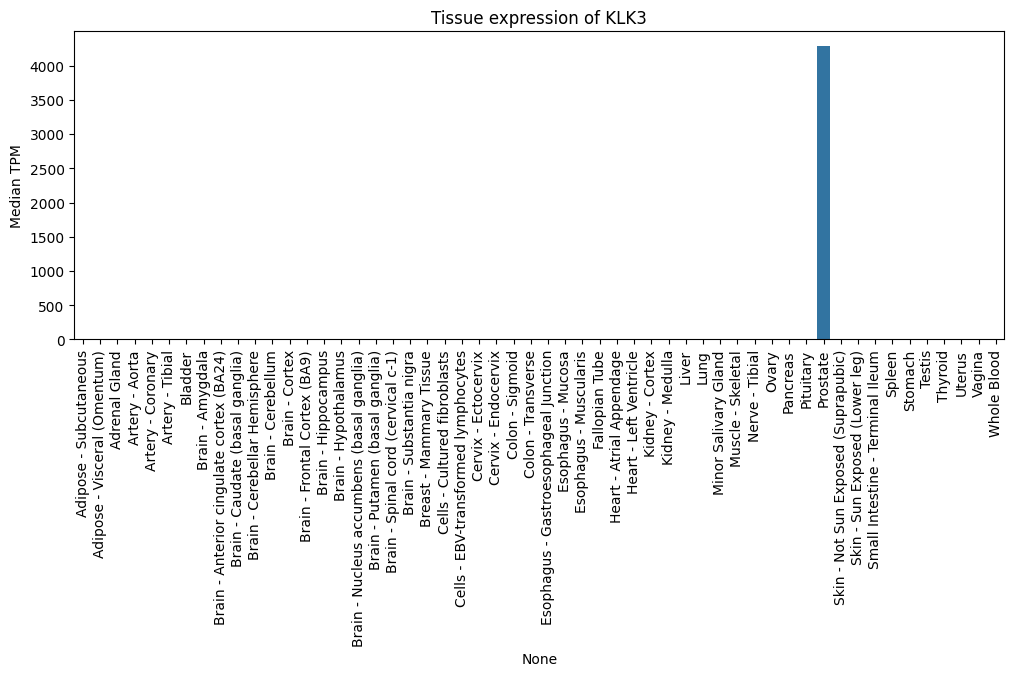

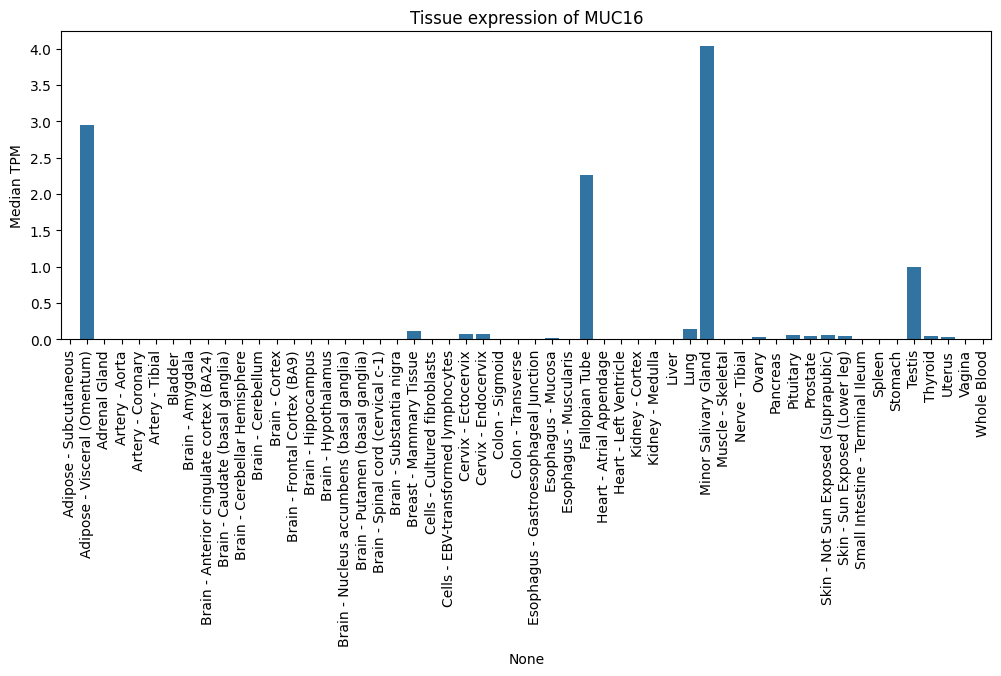

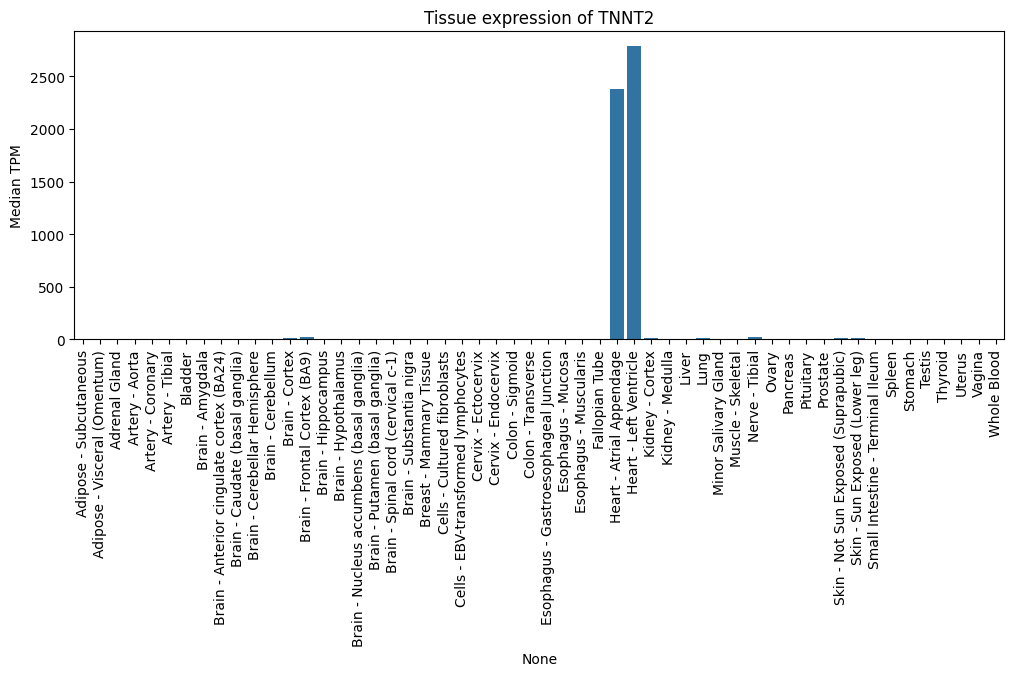

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for gene in positive_controls:
    plt.figure(figsize=(12,4))
    sns.barplot(x=tissue_cols, y=med_tpm_df.loc[med_tpm_df['gene']==gene, tissue_cols].values[0])
    plt.xticks(rotation=90)
    plt.title(f"Tissue expression of {gene}")
    plt.ylabel("Median TPM")
    plt.show()

#### Positive Controls + Top Tissue-Specific Candidates

In [23]:
import pandas as pd

# Make sure gz_med is defined to your GTEx median TPM file
# gz_med = '/content/drive/MyDrive/2025/BenchSci_Hackathon/gtex_GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'

# Load GTEx (skip the 2 metadata rows)
gtex = pd.read_csv(gz_med, sep="\t", skiprows=2, compression="gzip")

# Clean column names
gtex.rename(columns={"Name": "ensembl_id", "Description": "gene_symbol"}, inplace=True)
gtex["ensembl_id"] = gtex["ensembl_id"].str.split(".").str[0]

In [25]:
import pandas as pd
import numpy as np

# Tissue columns
tissue_cols = gtex.columns[2:-1]  # exclude ensembl_id, gene_symbol, tau

# Function to find tissue with max expression
def max_tissue(row):
    tissue_values = row[tissue_cols]
    max_tiss = tissue_values.idxmax()
    max_val = tissue_values.max()
    return pd.Series([max_tiss, max_val])

# Positive controls
positive_controls = ["KLK3", "MUC16", "TNNT2"]

# Subset for positive controls
pc_df = gtex[gtex['gene_symbol'].isin(positive_controls)].copy()
pc_df[['max_tissue', 'max_tpm']] = pc_df.apply(max_tissue, axis=1)

#### Add Clinical Relevance Rationale

In [36]:
# Manual clinical rationale
clinical_rationale = {
    "KLK3": "Prostate-specific antigen, biomarker for prostate cancer.",
    "MUC16": "CA-125, elevated in ovarian cancer.",
    "TNNT2": "Cardiac troponin, marker for heart injury."
}

pc_df['clinical_rationale'] = pc_df['gene_symbol'].map(clinical_rationale)

#### Rank by Tissue Specificity (Tau)

In [38]:
# --- Ensure a tau column exists on gtex and pc_df, then sort & display ---

import numpy as np
import pandas as pd

# 1) Identify tissue columns (exclude metadata/analytics)
tissue_cols = [c for c in gtex.columns if c not in ["ensembl_id", "gene_symbol", "tau", "Tau Score"]]

# 2) Compute tau on gtex if neither 'tau' nor 'Tau Score' exists
def tau_specificity(df: pd.DataFrame, value_cols: list) -> pd.Series:
    X = df[value_cols].to_numpy(dtype=float)
    max_x = X.max(axis=1)
    safe_max = np.where(max_x == 0.0, 1.0, max_x)
    x_norm = X / safe_max[:, None]
    n = X.shape[1]
    return pd.Series((1.0 - x_norm).sum(axis=1) / (n - 1), index=df.index, name="tau")

if "tau" not in gtex.columns and "Tau Score" not in gtex.columns:
    gtex["tau"] = tau_specificity(gtex, tissue_cols)

# 3) Attach tau to pc_df if it's not already there
if "tau" not in pc_df.columns and "Tau Score" not in pc_df.columns:
    if "tau" in gtex.columns:
        pc_df = pc_df.merge(gtex[["ensembl_id", "tau"]], on="ensembl_id", how="left")
    else:
        pc_df = pc_df.merge(gtex[["ensembl_id", "Tau Score"]], on="ensembl_id", how="left")

# 4) Pick the available tau column name
tau_col = "tau" if "tau" in pc_df.columns else ("Tau Score" if "Tau Score" in pc_df.columns else None)
if tau_col is None:
    raise KeyError("No tau column found or computed on pc_df.")

# 5) Sort and display
pc_df = pc_df.sort_values(tau_col, ascending=False)
pc_df[["gene_symbol", "max_tissue", "max_tpm", tau_col, "clinical_rationale"]]

,gene_symbol,max_tissue,max_tpm,tau,clinical_rationale
2,KLK3,Prostate,4285.71000,0.999942,"Prostate-specific antigen, biomarker for prost..."
0,TNNT2,Heart - Left Ventricle,2785.90000,0.982679,"Cardiac troponin, marker for heart injury."
1,MUC16,Minor Salivary Gland,4.03473,0.966827,"CA-125, elevated in ovarian cancer."


#### Example Use Case: Prostate Cancer

In [39]:
# Filter candidate biomarkers for prostate cancer (high expression in prostate)
prostate_candidates = gtex.copy()
prostate_candidates['max_tissue'] = prostate_candidates.apply(max_tissue, axis=1)[0]
prostate_candidates['max_tpm'] = prostate_candidates.apply(max_tissue, axis=1)[1]

# Filter tissue-specific genes in prostate (tau > 0.85 and max_tissue = 'Prostate')
prostate_candidates = prostate_candidates[
    (prostate_candidates['tau'] > 0.85) &
    (prostate_candidates['max_tissue'] == 'Prostate')
]

# Show top 5 candidates
prostate_candidates[['gene_symbol', 'max_tissue', 'max_tpm', 'tau']].head(5)

,gene_symbol,max_tissue,max_tpm,tau
1474,TTC39A-AS1,Prostate,1.334200,0.910697
1557,GLIS1,Prostate,12.886600,0.856242
1636,RP4-592A1.4,Prostate,0.414258,0.946248
1662,LINC01748,Prostate,2.241670,0.912107
2224,RP5-837M10.4,Prostate,0.056786,1.000000


#### Cardiovascular Example

In [33]:
# Heart-specific genes (tau > 0.85 and max_tissue contains 'Heart')
heart_candidates = gtex.copy()
heart_candidates['max_tissue'] = heart_candidates.apply(max_tissue, axis=1)[0]
heart_candidates['max_tpm'] = heart_candidates.apply(max_tissue, axis=1)[1]

heart_candidates = heart_candidates[
    (heart_candidates['tau'] > 0.85) &
    (heart_candidates['max_tissue'].str.contains('Heart'))
]

# Top 5 heart biomarkers
heart_candidates[['gene_symbol', 'max_tissue', 'max_tpm', 'tau']].head(5)

,gene_symbol,max_tissue,max_tpm,tau
361,NPPA,Heart - Atrial Appendage,28754.000000,0.999877
362,NPPB,Heart - Atrial Appendage,1639.560000,0.999383
363,RP5-934G17.6,Heart - Atrial Appendage,0.321284,0.940049
487,HSPB7,Heart - Left Ventricle,1825.310000,0.939931
943,FABP3,Heart - Left Ventricle,2578.970000,0.966039


#### Cardiovascular Example 2(with TPM > 1500 threshold)

In [34]:
# Compute max tissue + max TPM ONCE
heart_candidates = gtex.copy()
heart_candidates[['max_tissue', 'max_tpm']] = heart_candidates.apply(max_tissue, axis=1)

# Filter:
# 1. Highly tissue specific (tau > 0.85)
# 2. Tissue contains "Heart"
# 3. Strong expression signal (max TPM > 1500)

heart_candidates = heart_candidates[
    (heart_candidates['tau'] > 0.85) &
    (heart_candidates['max_tissue'].str.contains('Heart')) &
    (heart_candidates['max_tpm'] > 1500)
]

# Top heart biomarkers
heart_candidates[['gene_symbol', 'max_tissue', 'max_tpm', 'tau']].head(10)

,gene_symbol,max_tissue,max_tpm,tau
361,NPPA,Heart - Atrial Appendage,28754.00,0.999877
362,NPPB,Heart - Atrial Appendage,1639.56,0.999383
487,HSPB7,Heart - Left Ventricle,1825.31,0.939931
943,FABP3,Heart - Left Ventricle,2578.97,0.966039
4043,TNNT2,Heart - Left Ventricle,2785.90,0.982679
9614,MYL3,Heart - Left Ventricle,3733.53,0.994105
20657,MYL7,Heart - Atrial Appendage,7135.04,0.998772
28627,ANKRD1,Heart - Atrial Appendage,2507.28,0.989167
34737,MYL2,Heart - Left Ventricle,14495.30,0.984023
36958,MYH6,Heart - Atrial Appendage,4609.46,0.998319


#### Expression Evidence + Clinical Relevance Table

In [35]:
# Combine all positive controls + top tissue-specific candidates (example)
candidate_biomarkers = pd.concat([pc_df, prostate_candidates, heart_candidates]).drop_duplicates('gene_symbol')

# Add clinical rationale where possible (manual or later from literature / HPA)
candidate_biomarkers['clinical_rationale'] = candidate_biomarkers['gene_symbol'].map(clinical_rationale)

# Final candidate table
candidate_biomarkers[['gene_symbol', 'max_tissue', 'max_tpm', 'tau', 'clinical_rationale']]

,gene_symbol,max_tissue,max_tpm,tau,clinical_rationale
2,KLK3,Prostate,4285.71000,0.999942,"Prostate-specific antigen, biomarker for prost..."
0,TNNT2,Heart - Left Ventricle,2785.90000,0.982679,"Cardiac troponin, marker for heart injury."
1,MUC16,Minor Salivary Gland,4.03473,0.966827,"CA-125, elevated in ovarian cancer."
1474,TTC39A-AS1,Prostate,1.33420,0.910697,NaN
1557,GLIS1,Prostate,12.88660,0.856242,NaN
...,...,...,...,...,...
36958,MYH6,Heart - Atrial Appendage,4609.46000,0.998319,NaN
36960,MYH7,Heart - Left Ventricle,4513.66000,0.981788,NaN
39200,ACTC1,Heart - Atrial Appendage,3411.94000,0.982508,NaN
44934,MYL4,Heart - Atrial Appendage,2518.25000,0.999120,NaN
